# First Principles of Transit Systems

This document attempts to model and evaluate the essential nature of transit systems using a simulations in python. I'll use these models to explore the first principles of transit. **First priciples** are the fundamental properties of a system that determine it's behavior. [Elon musk used these to explain why batteries and space travel could become much cheaper](http://www.businessinsider.com/elon-musk-first-principles-2015-1). 

A future document will explore the cost structures of different transit modes and how they could capture these opportunities.  
 
Here I've tried to quantify the assumptions so they can be challenged explicity.


Will Roscoe  - [wroscoe.com](http:wroscoe.com) 

-------


### Approach 

We'll model the key objects and process of a transit system. Then we'll simulate how the model changes over time. To keep the model simple it will only operate in 1 dimension (time). Each step of the model moves through one step in time.

First lets define the terms we'll be using: 

#### Objects
1. **rider** - a person with a destination (end stop)
2. **vehicle** - the container that moves riders to their end stop along a path
3. **path** - how vehicles can move between stops
4. **stop** - a point along a route where a vehicle can load/unload riders
 
#### Processes
1. **move** - a vehicle has to move along a route
2. **unload vehicle** - riders transfered from a vehicle to a stop. 
3. **load vehicle** - riders transfered from stop to vehicle. 
4. **create new riders** - create riders that are waiting to be picked up
 
#### Key Measurments
* **trip time** - time for rider to get to their destination
* **flow** - riders passing a point over time (usually measured at each station)

#### Variables
One thing that makes transit systems tricky is that they have so many variables. changing more than one of these at a time makes it dificutle to identify which variable has the effect. 

vehicle frequency -  vehicle capacity - number of vehicles - vehicle schedule - path shapes - number of stations - time between stations -  time vehicles spend at stop -  number of new passengers - destinations of new passengers, 

## TLDR - What we've learned.

#### Circular paths
1. Adding vehicles **sometimes** reduce  rider waite times.
2. Increasing frequency of vehicles **always** reduces rider wait times.




## Hypotheses  - What's next
1. Rider speed increases when routes are more connected. 
2. Rider speed increases with the frequency of vehicles. 
3. System capacity increases with frequency and vehicle capacity
4. Distribution of rider demands d




## Riders
To measure wait time and efficiency we need to know where people want to go and what time they started their journey. For this I represent a rider as a tuple (destination stop, time trip began)


In [42]:
class Riders(list):
    def __init__(self, *args):
        list.__init__(self, *args)

    def put(self, riders):
        ''' add riders'''
        self += riders
        
    def get(self, matches=None, n=None):
        ''' return matching riders and remove them'''
        
        removed = []
        removed_index = []
        
        if n is None and n != 0: 
            n = len(self)
        
        if matches is None:
            removed = self[:n] #get all riders
            del self[:n] #remove riders
        
        else:
            i = 0
            for r in self:
                if i == n: break
                    
                if r[0] in matches:
                    removed.append(r)
                    removed_index.append(i)
                    i += 1
                    
                
    
                
            
        for i in sorted(removed_index, reverse=True):
            del self[i]
                    
        return removed
        

In [44]:
riders = Riders([('A',3), ('B',4),('B',2)])
riders.put([('C', 5)])
riders.get(matches=['A', 'C'], n=1)

[('A', 3)]

## Stops 
Stops are containers for riders

In [27]:
class Stop():
    def __init__(self, name, riders):
        self.name = name
        self.riders = riders
        
    def load(self, riders):
        ''' add riders to the stop'''
        self.riders += riders
        
    def unload(self, n=None, matches=None):
        ''' take riders from the stop'''
        riders = self.riders.get(n=n, matches=matches)
        return riders
    

In [28]:
s = Stop('A', riders)
s.riders
s.load(riders)
s.riders

[('B', 2), ('C', 5), ('B', 2), ('C', 5)]

## Paths

Paths are a representation of how a vehicle can travel. 

In [139]:
class CirclePath():
    
    def __init__(self, stop_names, durations):
        self.stops = stop_names
        self.durations = durations
        
    def next_stops(self, start):
        ''' return a list of the next possible stops and their duration'''
        index = self.stops.index(start)
        if index == len(self.stops)-1:
            index = -1
        
        S = [(self.stops[index+1], self.durations[index+1] )]
        return S
    
path = CirclePath(list('ABCDE'), [10]*5)
path.next_stops('E')

[('A', 10)]

## Vehicles

In [128]:
class Vehicle():
    def __init__(self, name, current_stop, capacity=10):
        self.name = name
        self.end_stop = current_stop #destinations
        self.t = 0 #time to destination
        self.riders = Riders() #riders object
        self.capacity = capacity #max riders
        
    def load(self, riders):
        ''' add riders to the stop'''
        self.riders += riders
        
    def unload(self, matches=None):
        unloaded = self.riders.get(matches=matches)
        return unloaded
    
    def spaces(self):
        ''' return how many riders can fit in the vehicle'''
        return self.capacity - len(self.riders)
    
    def move(self):
        ''' move one step in time closer to the stop'''
        self.t -= 1
        
    def set_route(self, end_stop, t):
        ''' set route for vehicle'''
        self.end_stop = end_stop
        self.t = t     

In [134]:
v = Vehicle('car', 'B', 10)
v.riders

[]

In [137]:
v.load(riders)
v.riders

[('B', 4), ('B', 2), ('B', 4), ('B', 2)]

## Generators

In [32]:
import random

def new_riders(n, stop_names, t): 
    riders = []
    for i in range(n):
        stop_name = random.sample(stop_names, 1)[0]
        t=t
        riders.append((stop_name, t))
    return Riders(riders)
        
    return [(random.sample(stop_names, 1)[0], t) for i in range(n)]

def new_vehicles(n, stop_names):
    vehicles = []
    for i in range(n):
        name = str(i)
        stop = stop_names[i]
        t = 0
        riders = new_riders(3, stop_names, 0)
        v = Vehicle(name, stop, t, riders, 20)
        vehicles.append(v)
    return vehicles


def new_stops(stop_names):
    stops = {}
    for s in stop_names:
        riders = new_riders(3, stop_names, 0)
        stop = Stop(s,riders)
        stops[stop.name] = stop
    return stops

## Data Recorder
Instead of using print statements, here is a simple recorder class to save data dictionaries and return them as a pandas DataFrame for easy ploting and metrics.

In [33]:
import pandas as pd

class Recorder ():
    def __init__(self):
        self.records = {}
        self.columns = {}

    def save(self, name, dct={}):
        if name not in self.records.keys():
            self.records[name]=[]
        self.records[name].append(dct)
        
    def get(self, name):
        df =  pd.DataFrame(self.records[name])
        df = df.fillna(0)
        return df

## Simulate.
To move through time, our simulation updates all our objects in every time. In this case we move each train forward in time 1 step, if the 

In [34]:
class Simulator():
    def __init__(self, vehicles, stops, path):
        
        self.R = Recorder()
        self.t=0 #initialize at time = 0

        #create dictionary of stop objects
        self.stops = stops

        #3 min between stops
        self.path = path 

        self.vehicles = vehicles

In [84]:

class TrainSimulator(Simulator):
    def __init__(self, vehicles, stops, path):
        super(TrainSimulator, self).__init__(vehicles, stops, path)

    
    def step(self):

        #remove passengers that have arrived at their end_stop
        for n, s in self.stops.items():
            s.unload(matches=[s.name])

        #set new routes
        for v in self.vehicles:
            if v.t == 0:#vehicle at station
                next_stop, t = self.path.next_stops(v.end_stop)[0]
                v.set_route(next_stop, t)

            #move vehicle
            v.move()


        #if vehicle is at a station
        for v in [v for v in self.vehicles if v.t <= 0]:

            #unload riders
            if v.t <= 0:
                unloaded = v.unload(v.end_stop)
                self.stops[v.end_stop].load(unloaded) #move unloaded passengers 

            #load riders
            if v.t <= 0:
                matches = [s for s in self.stops.keys() if s != v.end_stop]
                boarding = self.stops[v.end_stop].unload(n=v.spaces(), matches=matches)
                v.load(boarding)

        #generate new riders at each stop
        for n, s in self.stops.items():
            stop_choices =[s for s in self.stops.keys() if s is not n]
            s.load(new_riders(random.randint(0,5), stop_choices , self.t))
            
            
    def run(self, end_time):
        for i in range(end_time):
            self.step()
            
            self.t += 1

            #save rider counts
            data_dict = dict([(v.name, len(v.riders)) for v in self.vehicles ])
            self.R.save('riders on vehicles', data_dict)

            #save station counts
            data_dict = dict([(n, len(s.riders)) for n, s in self.stops.items() ])
            self.R.save('riders at stops', data_dict)
            
            #trip durations of riders that arrive at their end stops
            for n,s in self.stops.items():
                
                data = [{'t':self.t, 'end_stop':s.name, 'duration':self.t - r[1]} for r in s.riders if r[0] == s.name ]
                for d in data:
                    self.R.save('trip durations', d)
            
        return self.R


Now we create the objects and loop over the step for the perod of time we want to simulate.

In [118]:
def new_train_sim(capacity=10, spacing=10):
    train1 = Vehicle('train1', 'B', capacity=capacity)
    train2 = Vehicle('train2', 'D', capacity=capacity)
    vehicles = [train1, train2]
    
    stop_names = list('ABCDE')
    stops = new_stops(stop_names)
    path = CirclePath(stop_names,[spacing]*len(stop_names))
    return TrainSimulator(vehicles, stops, path)

TS = new_train_sim(capacity=3, spacing=3)
R  = TS.run(300)


## Visualize the number of riders waiting at each stop.
Here are we visualize the number of riders at each stop over time. The capacity of the system does not support the rider demand because the number of riders waiting increases over time.

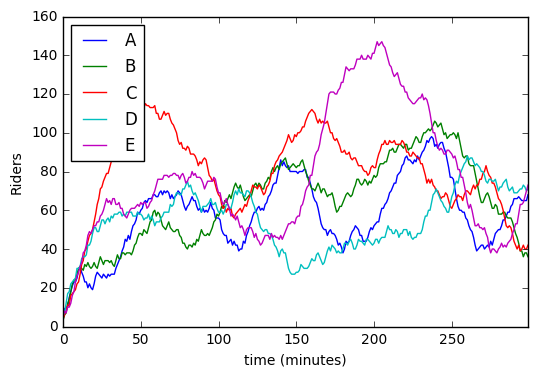

In [119]:
%matplotlib inline 

df = R.get('riders at stops')
ax = df.plot()
ax.set_xlabel('time (minutes)')
ax.set_ylabel('Riders')


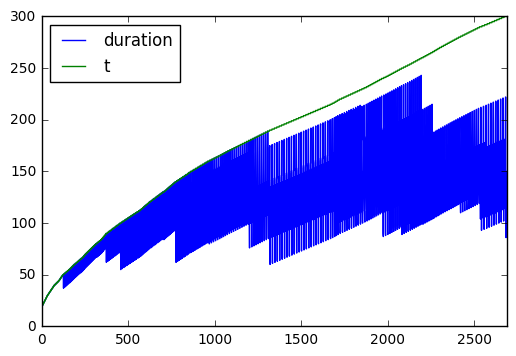

In [113]:
df = R.get('trip durations')
df.plot()

## How does train capacity affect the number of waiting riders?
To find the train capacity is needed for this riding demand lets simulate several different capacities until the number or waiting riders remains constant. 

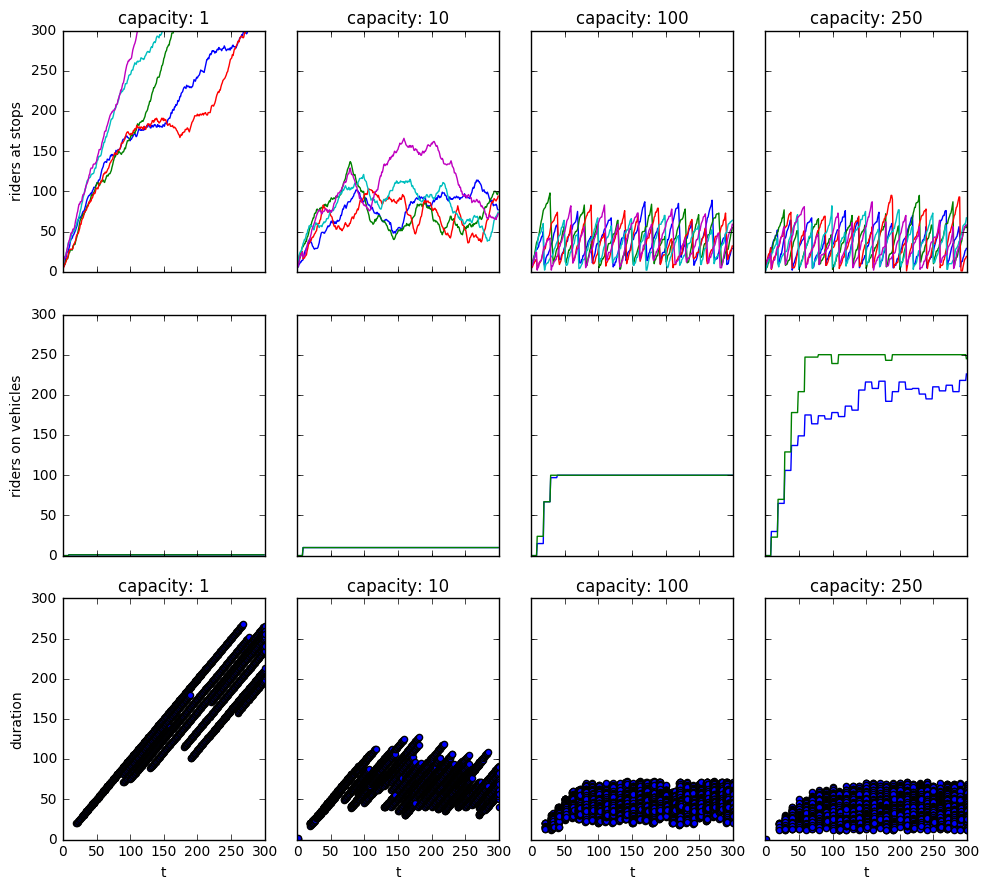

In [120]:
import matplotlib.pyplot as plt 
plt.rcParams["figure.figsize"] = [10,9]

def show(capacities):
    fig, axes = plt.subplots(nrows=3, ncols=4)
    for i, c in enumerate(capacities):
        TS = new_train_sim(capacity=c)
        
        steps = 300
        R = TS.run(steps)

        xlim=[0,steps]
        ylim=[0,300]
        
        df = R.get('riders at stops')
        ax = df.plot(ax=axes[0, i], title="capacity: " + str(c), 
                    legend=False, sharey=True, sharex=True,
                    xlim=xlim, ylim=ylim)
        ax.set_ylabel('riders at stops')

        df = R.get('riders on vehicles')
        ax = df.plot(ax=axes[1, i],
                    legend=False, sharey=True, sharex=True,
                    xlim=xlim, ylim=ylim)
        ax.set_ylabel('riders on vehicles')
        
        df = R.get('trip durations')
        df.plot.scatter(x='t', y='duration', ax=axes[2, i], title="capacity: " + str(c), 
                                      legend=False, sharey=True, xlim=xlim, ylim=ylim)

    plt.tight_layout()
    
show(capacities = [1, 10, 100, 250])

**Capacity=1**
* Riders are created faster than the vehicles can transport them. 

**Capacity=2**
* Riders are still not 

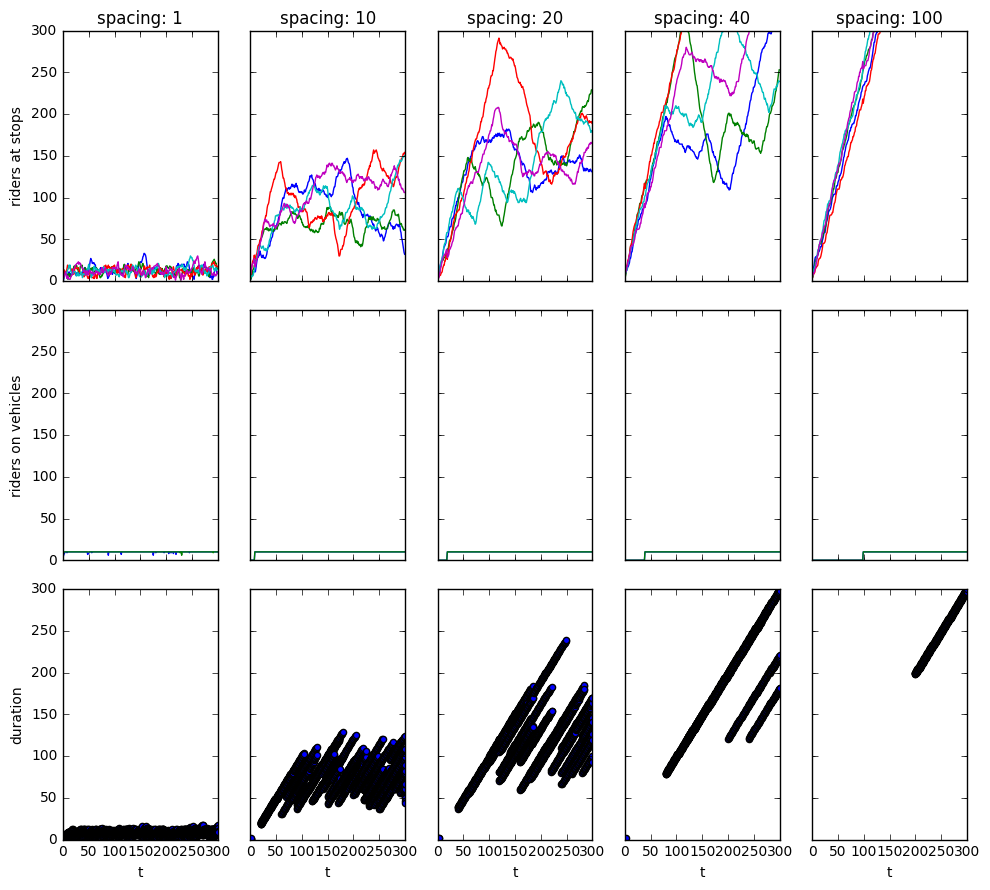

In [127]:
def show(spacings):
    fig, axes = plt.subplots(nrows=3, ncols=len(spacings))
    for i, s in enumerate(spacings):
        TS = new_train_sim(capacity=10, spacing=s)
        
        steps = 300
        R = TS.run(steps)

        xlim=[0,steps]
        ylim=[0,300]
        
        df = R.get('riders at stops')
        ax = df.plot(ax=axes[0, i], title="spacing: " + str(s), 
                    legend=False, sharey=True, sharex=True,
                    xlim=xlim, ylim=ylim)
        ax.set_ylabel('riders at stops')

        df = R.get('riders on vehicles')
        ax = df.plot(ax=axes[1, i],
                    legend=False, sharey=True, sharex=True,
                    xlim=xlim, ylim=ylim)
        ax.set_ylabel('riders on vehicles')
        
        df = R.get('trip durations')
        df.plot.scatter(x='t', y='duration', ax=axes[2, i], 
                                      legend=False, sharey=True, xlim=xlim, ylim=ylim)

    plt.tight_layout()
    
show([1, 10, 20, 40, 100])

## New riders from distributions of destimation demand.

In [15]:
from math import cos, pi

def map_dist(name, n):
    """ return an distribution between 0 and 1 over a list of n   """
    if name == 'uniform': 
        dist = [1 for _ in range(n)] #all 1s
        
    elif name == 'peak':
        dist = [(-cos(i/n*2*pi)+1) / 2 for i in range(n)]
    return dist


In [16]:
# Oakland <> San Francisco Transbay tube

## Metrics 

In [17]:
def metrics (name, R):
    if name == 'ave flow by station':   return R.get('flow').sum()/len(R.get('flow'))
    elif name == 'max flow by station': return R.get('flow').max().copy()
    
    elif name == 'riders by time':      return R.get('riders').sum(axis=1)
    
    elif name == 'system ave riders':   return R.get('riders').sum(axis=1).mean()
    elif name == 'system ave flow':     return R.get('flow').mean().mean()
    else: print('NO METRICS FOUND')
    
    
metrics('ave flow by station', R)

KeyError: 'flow'